In [1]:
import os
import sys

import matplotlib.pyplot as plt
import tensorflow as tf
from keras import backend as K
from skimage import io

from data_generator import *
from unet3d import *
# from unet3d_dense import *
# from unet3d_dense_rec import *
from unet3d_res import *
from tensorflow.keras.preprocessing.image import (
    ImageDataGenerator,
    img_to_array,
    load_img
)

sys.path.append("../")
from dice_loss import *


Using TensorFlow backend.


In [2]:
TRAIN_PATH = 'data/train/'
XTRAIN_PATH = f'{TRAIN_PATH}/image'
YTRAIN_PATH = f'{TRAIN_PATH}/label'

TEST_PATH = 'data/test/'
XTEST_PATH = f'{TEST_PATH}/image'
YTEST_PATH = f'{TEST_PATH}/label'

# STEPS=2000
STEPS = 50
EPOCHS=2
# EPOCHS = 1
MODEL_NAME = 'unet_lidc.hdf5'

## Data Generation and Augmentation

In [3]:
image_generator_train = ImageDataGenerator(
    rotation_range=2,
    rescale=1./255,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

label_generator_train = ImageDataGenerator(
    rotation_range=2,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.0
)

image_generator_test = ImageDataGenerator(
    rescale=1./255,
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

label_generator_test = ImageDataGenerator(
    # No rescale transform on target mask
    fill_mode='reflect',
    data_format='channels_last',
    validation_split=0.0
)

In [4]:
train_generator = generator(
    TRAIN_PATH,
    image_generator_train,
    label_generator_train,
    batch_sz=1,
)
test_generator = generator(
    TEST_PATH,
    image_generator_test,
    label_generator_test, 
    batch_sz=1
)

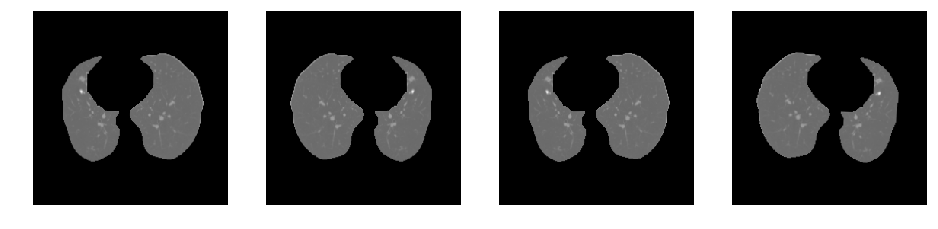

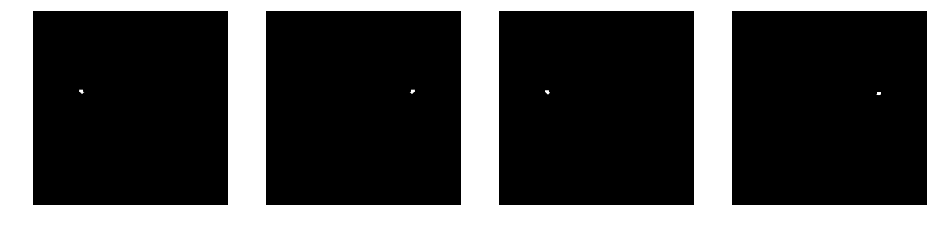

In [5]:
show_augmentation('data/train/image2/1.tif', image_generator_train, n_rows=1)
show_augmentation('data/train/label2/1.tif', label_generator_train, n_rows=1)

## Instantiate and Train the U-Net

In [6]:
# model = unet3d()
model = unet3d_res()
model.compile(
    optimizer = Adam(lr=1e-5),
    loss=dice_coef_weighted_loss,
    metrics = [
        'accuracy',
        dice_coef,
        tf.keras.metrics.Precision(),
        tf.keras.metrics.Recall(),
        tf.keras.metrics.TrueNegatives(),
        tf.keras.metrics.TruePositives()
    ]
)
model_checkpoint = ModelCheckpoint(MODEL_NAME, monitor='loss',verbose=1, save_best_only=True)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [7]:
model.fit_generator(
  train_generator,
  steps_per_epoch = 1000,
  epochs = 10
)

Found 332 images belonging to 1 classes.
Found 332 images belonging to 1 classes.
Found 332 images belonging to 1 classes.
Found 332 images belonging to 1 classes.
Found 332 images belonging to 1 classes.
Found 332 images belonging to 1 classes.
Found 332 images belonging to 1 classes.
Found 332 images belonging to 1 classes.
Epoch 1/10
1000/1000 [==============================] - 401s 401ms/step - loss: 0.9952 - acc: 0.9503 - dice_coef: 8.0064e-04 - precision: 0.0064 - recall: 0.3146 - true_negatives: 249114144.0000 - true_positives: 82531.0000
Epoch 2/10
1000/1000 [==============================] - 384s 384ms/step - loss: 0.9871 - acc: 0.9988 - dice_coef: 0.0022 - precision: 0.4806 - recall: 0.2322 - true_negatives: 261816672.0000 - true_positives: 60743.0000
Epoch 3/10
1000/1000 [==============================] - 383s 383ms/step - loss: 0.9827 - acc: 0.9988 - dice_coef: 0.0030 - precision: 0.6100 - recall: 0.2626 - true_negatives: 261835056.0000 - true_positives: 69469.0000
Epoch 4/

## Test the U-Net

### Training set predictions

In [19]:
# results = model.predict(X_test, 2, verbose=1)

idx = 9

x0 = np.array(io.imread(f'data/train/image0/{idx}.tif', as_gray=True))
x1 = np.array(io.imread(f'data/train/image1/{idx}.tif', as_gray=True))
x2 = np.array(io.imread(f'data/train/image2/{idx}.tif', as_gray=True))
x3 = np.array(io.imread(f'data/train/image3/{idx}.tif', as_gray=True))

X = np.array([x0, x1, x2, x3])

y0 = np.array(io.imread(f'data/train/label0/{idx}.tif', as_gray=True))
y1 = np.array(io.imread(f'data/train/label1/{idx}.tif', as_gray=True))
y2 = np.array(io.imread(f'data/train/label2/{idx}.tif', as_gray=True))
y3 = np.array(io.imread(f'data/train/label3/{idx}.tif', as_gray=True))

Y = np.array([y0, y1, y2, y3])

Y_hat = model.predict(X.reshape(1, 256, 256, 4, 1))

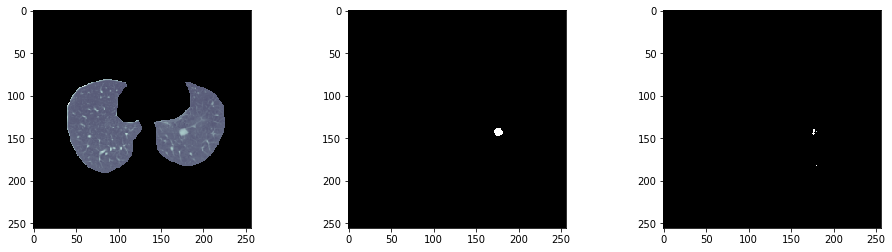

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].imshow(X[2], cmap='bone')
axs[1].imshow(Y[2], cmap='bone')
axs[2].imshow(Y_hat[0].reshape(4, 256, 256)[2], cmap='bone')
plt.show()

### Test set predictions

In [21]:
# results = model.predict(X_test, 2, verbose=1)

x0 = np.array(io.imread('data/test/image0/4.tif', as_gray=True))
x1 = np.array(io.imread('data/test/image1/4.tif', as_gray=True))
x2 = np.array(io.imread('data/test/image2/4.tif', as_gray=True))
x3 = np.array(io.imread('data/test/image3/4.tif', as_gray=True))

X = np.array([x0, x1, x2, x3])

y0 = np.array(io.imread('data/test/label0/4.tif', as_gray=True))
y1 = np.array(io.imread('data/test/label1/4.tif', as_gray=True))
y2 = np.array(io.imread('data/test/label2/4.tif', as_gray=True))
y3 = np.array(io.imread('data/test/label3/4.tif', as_gray=True))

Y = np.array([y0, y1, y2, y3])

Y_hat = model.predict(X.reshape(1, 256, 256, 4, 1))

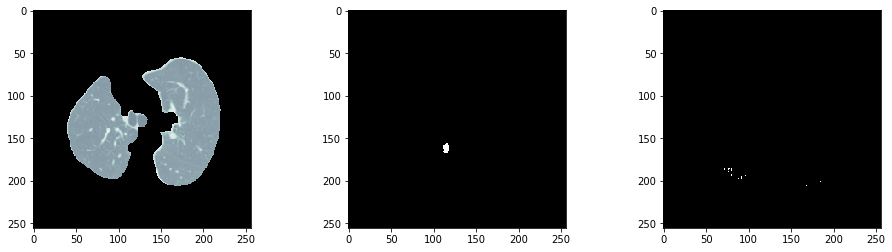

In [22]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

axs[0].imshow(X[2], cmap='bone')
axs[1].imshow(Y[2], cmap='bone')
axs[2].imshow(Y_hat[0].reshape(4, 256, 256)[2], cmap='bone')
plt.show()